In [36]:
import numpy as np
from scipy import signal
import os

import torch
from torch import nn

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

%matplotlib inline

## How the mapping works

Postsynaptic currents can be modeled as

<img src="imgs/discrete time postsynaptic dynamics.svg"/>

We can see the unfolding in time of the state of a LIF neuron when mapping it to a RNN:

<img src="imgs/snn_graph.png" width=80%/>

Now let's implement a simple feed-forward network with one hidden layer

In [11]:
nb_inputs = 100
nb_hidden = 4
nb_outputs = 2

time_step = 1e-3
nb_steps = 200
batch_size = 256

dtype = torch.float
device = torch.device("cpu")

## Generate synthetic data

In [13]:
freq = 5 
prob = freq*time_step #instantaneous spike probability

mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device,
                 dtype=dtype)

x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device,
                    dtype=dtype, requires_grad=False)

x_data[mask < prob] = 1.0

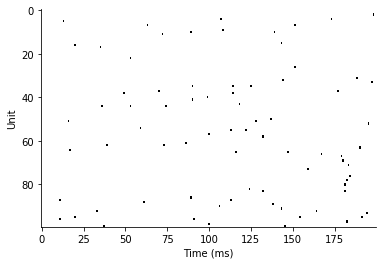

In [14]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [18]:
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

## Implement LIF model

In [24]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_syn))

# weight matrices
weight_scale = 7*(1. - beta) 

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype,
                requires_grad=True)
nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype,
                requires_grad=True)
nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

tensor([[-0.3011,  0.0918],
        [-0.0153,  0.0715],
        [ 0.0603, -0.1612],
        [ 0.0668,  0.1235]], requires_grad=True)

## Multiply all the input spikes by weight matrix

In [25]:
h1 = torch.einsum("abc, cd->abd", (x_data, w1)) # pretty cool

In [30]:
def spike_fun(x):
    "naive implementation"
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [32]:
syn = torch.zeros((batch_size, nb_hidden), dtype=dtype)
mem = torch.zeros((batch_size, nb_hidden), dtype=dtype)

mem_rec = [mem]
spk_rec = [mem] # record membrane potentials and spikes

for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fun(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    
    new_syn = alpha*syn + h1[:,t]
    new_mem = beta*mem + syn -rst
    
    mem = new_mem
    syn = new_syn
    
    mem_rec.append(mem)
    spk_rec.append(out)
    
mem_rec = torch.stack(mem_rec, dim=1)
spk_rec = torch.stack(spk_rec, dim=1)

In [34]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = (mem + spike_height * spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
        
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

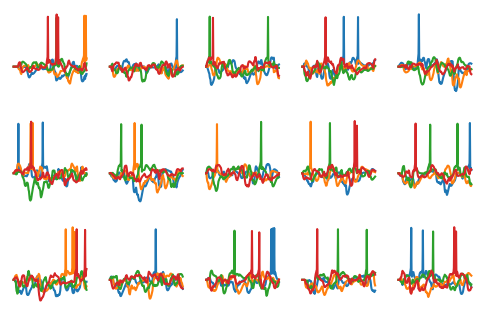

In [37]:
fig = plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

## Add readout layer

In [91]:
def run_snn(inputs, device=device):
    
    # hidden layer
    h1 = torch.einsum("abc, cd-> abd", (inputs, w1))
    syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    
    mem_rec = [mem]
    spk_rec = [mem]
    
    for t in range(nb_steps):
        mthr = mem-1. # threshold of 1.0
        out = spike_fun(mthr)
        rst = torch.zeros_like(mem)
        c = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        
        new_syn = alpha*syn + h1[:,t]
        new_mem = beta*mem + syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)
    
    # readout layer
    h2 = torch.einsum("abc, cd -> abd", (spk_rec, w2))
    flt = torch.zeros((batch_size, nb_outputs),
                     device=device, dtype=dtype)
    out = torch.zeros((batch_size, nb_outputs),
                     device=device, dtype=dtype)
    out_rec = [out]
    
    for t in range(nb_steps):
        new_flt = alpha*flt + h2[:,t]
        new_out = beta*out + flt
        
        flt = new_flt
        out = new_out
        out_rec.append(out)
        
    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [41]:
out_rec, other_recs = run_snn(x_data)

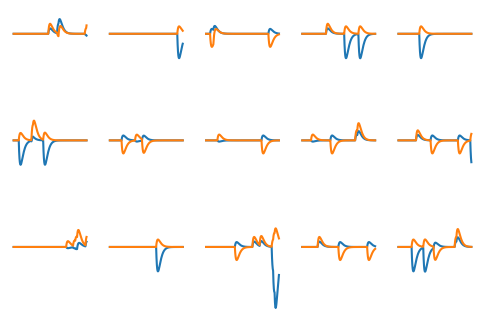

In [42]:
fig = plt.figure(dpi=100)
plot_voltage_traces(out_rec)

### The whole way this works is by preventing the output neurons from spiking: it provides a reasonably smooth objective to differentiate

We use the maximum voltage over time of each unit 

$$ \hat{U}^{out}_i = max_t U^{out}_i (t) $$

and take an argmax or softmax and negative log likelihood loss to update the network's weights

In [60]:
def print_classification_accuracy():
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1) # max over time
    _, am = torch.max(m, 1) # argmax over output units
    acc = np.mean((y_data==am.int()).detach().cpu().numpy())
    print("Accuracy {}".format(acc))
    
print_classification_accuracy()

Accuracy 0.48828125


## Supervised learning

In [76]:
params = [w1, w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))

log_softmax = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss() # neg log likelihood

loss_hist = []
for e in range(1000):
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1)
    log_p_y = log_softmax(m)
    loss_val = loss_fn(log_p_y, y_data.type(torch.long))
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist

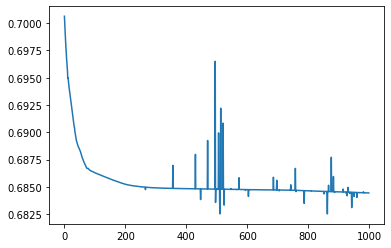

In [77]:
plt.plot(loss_hist_true_grad)

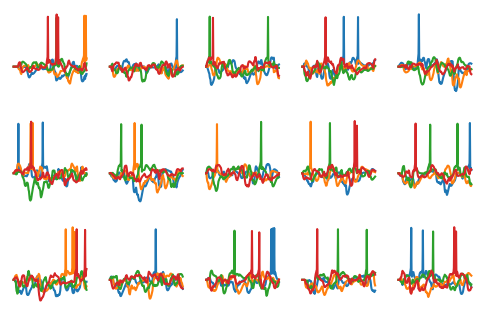

In [78]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

### The accuracy doesn't increase much because the spiking function has zero derivative everywhere except the threshold crossing, where it's infinite. Only the outputs change:

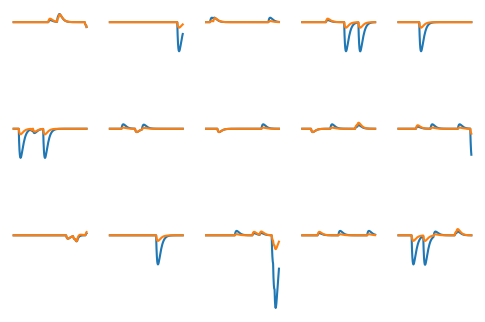

In [83]:
plt.figure(dpi=100)
plot_voltage_traces(output)

## Use surrogate gradient to overcome this problem

Use a fast sigmoid function to approximate the heaviside function. It needs to be scaled since it's not invariant to multiplicative rescaling

In [84]:
class SuperSpike(torch.autograd.Function):
    '''This overwrites the "spike_fun" '''
    scale = 100.0 # gradient steepness
    
    @staticmethod
    def forward(ctx, input):
        '''ctx saves informationfor backpropagating error signals'''
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SuperSpike.scale * torch.abs(input)+1.)**2
        return grad


In [101]:
spike_fun = SuperSpike.apply
device = torch.device("cpu")

In [102]:
w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype,
                requires_grad=True)
nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype,
                requires_grad=True)
nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden));

In [103]:
params = [w1, w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))

log_softmax = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss() # neg log likelihood
y_data = y_data.to(device)
loss_hist = []
for e in range(1000):
    output, _ = run_snn(x_data.to(device), device)
    m, _ = torch.max(output, 1)
    log_p_y = log_softmax(m)
    loss_val = loss_fn(log_p_y, y_data.type(torch.long))
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist

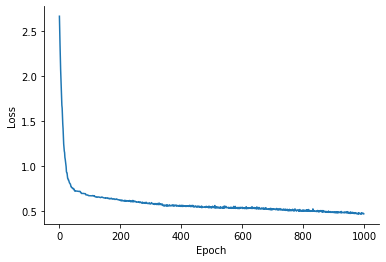

In [105]:
plt.plot(loss_hist_true_grad)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

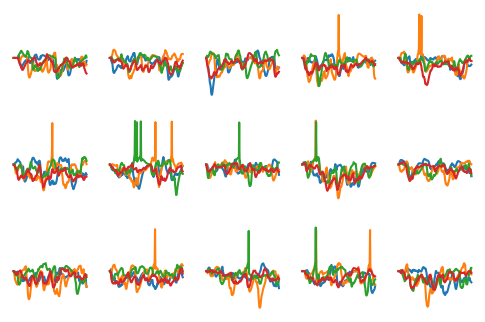

In [109]:
output,other_recordings = run_snn(x_data, device)
mem_rec, spk_rec = other_recordings

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

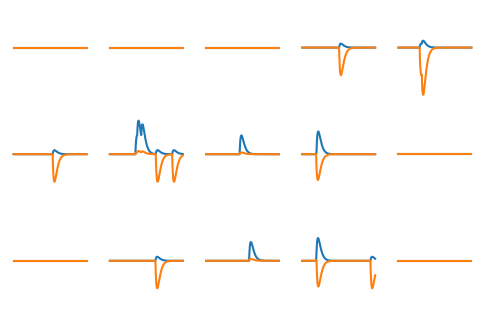

In [110]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [112]:
_,am=torch.max(m,1)
acc = np.mean((y_data==am.int()).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.886719
